Kernel to use here : *base (Python3.9.13)*

**TO DO :**
- Reprendre les analyses d'Alice. Comment sont générés les QT de la figure 
- 2ème analyse test : pour 1 objet visité, plotter la trajectoire de chaque QT fait autour de cet objet. Le début de la trajectoire doit se trouver au centre du graphique. Tous les QT doivent donc début au même centre. A faire d'abord pour les 10 premiers objets visités.
- 3ème analyse test : plotter la distribution des vitesses des QT en fonction du temps et ce pour chaque objet visité. 
- Une fois qu'on obtient les analyses voulues, passer ce qui est possible en fonction (facilitera l'incorporation dans le fichier MouseTache + accélère le processus d'analyse)
- Régler les échelles de chaque graphique
- Créer une seule figure avec toutes les analyses pour chaque objet. A redimensionner correctement à la fin. 

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.ndimage import gaussian_filter as smooth
from own_Functions_05_4 import *
from median_thomas import *
import gc
from IPython.display import clear_output

#Intialize the value of some variables and define some important global variables
REMAINING_REWARDS = False # if true, indicate the number of reward available on an object when the mouse starts to go around

MINIMAL_DURATION_STOP = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
MINIMAL_DURATION_EPOCH = 0.3 #minimal duration of an epoch to be considerd
TRAPEZE_SIZE = 35 #how much to extend outside of the objects to detect the trajectories
Resolution = 512,512 #variable which store the size of the experimental field in pixels
true_sigma = 1 #the sigma used for the remaining of the analysis
true_cut_speed = 7 #value to be used for the remaining of the analysis
true_ecart_angle = 1 #if a change is made, must change timeofframes

## Tests : plot the trajectories of QT from Alice's analysis

#### First : plot the trajectory around the first visited object, 1 second before the animal enters in it and 1 second after it left
#### Done for the 10 first visited objects

In [11]:
Folder_path = '/home/david/MyLocalData/Maud/' #Path for Linux
#Folder_path = 'C:\\Users\\mauds\\Documents\\WORKING_FROM_HOME\\SampleDatas_Batch6\\' #Path for Windows
mouseName = 'MOU4437'
session = 'MOU4437_20240313-1144'

In [66]:
# Tests for turns_df 

csv_turns_path = Folder_path + mouseName + '/' + session + '/' + session + '_turnsinfo.csv'

# Lis le fichier csv obtenu à la fin de la manip
turns_df = pd.read_csv(csv_turns_path)

# Sélectionne les valeurs pour lesquelles le temps est supérieur à 15 sec (problèmes de détecttion avant 15 sec)
turns_df=turns_df.loc[turns_df["time"]>15]

# Reset les index dans le dataframe pour démarrer à 0
turns_df=turns_df.reset_index(drop=True)

# Montre à quoi ressemble df
print(turns_df)

        time  framenumber  xposition  yposition currentPatch previousTrapeze  \
0     15.915          360         79        230           NW               W   
1     16.953          386        202        336           SW               N   
2     17.833          408        191        425           SW               E   
3     18.794          432        100        399           SW               S   
4     19.596          452         97        336           SW               W   
..       ...          ...        ...        ...          ...             ...   
667  711.526        17741        404        327           SE               E   
668  712.808        17773        412        203           NE               S   
669  713.646        17794        406        111           NE               E   
670  714.408        17813        305        105           NE               N   
671  715.527        17841        302        242           NE               W   

    currentTrapeze  turnDirection ongoi

In [72]:
# Création d'un dataframe pour plotter la trajectoire de chaque objet 

# turns_df = dataframe du tableur "turnsinfos" généré à la fin des sessions
# df = dataframe qui contient, à chaque fois que la souris visite un objet, quel objet est visité + à quel moment elle a commencé son premier turn + le temps du dernier QT

objets_visites = []
temps_entree = []
#nb_QT = []
temps_sortie = []
current_patch = None

for index, row in turns_df.iterrows():
    # Si c'est la première ligne ou si le current_patch a changé
    if index == 0 or row['currentPatch'] != turns_df.iloc[index - 1]['currentPatch']:

        # Sauvegarde du currentPatch dans la liste des objets visités
        objets_visites.append(row['currentPatch'])
        
        # Sauvegarde du temps d'entrée
        temps_entree.append(row['time'])
        
        # Si ce n'est pas la première ligne, sauvegarder le temps de sortie précédent
        if index != 0:
            temps_sortie.append(turns_df.iloc[index - 1]['time'])
            #nb_QT.append(turns_df.iloc[index - 1]['nberOfConsecRewards'])

# Ajouter le temps de sortie pour la dernière ligne
if not turns_df.empty:
    temps_sortie.append(turns_df.iloc[-1]['time'])
    #nb_QT.append(turns_df.iloc[-1]['nberOfConsecRewards'])

# Création du DataFrame à partir des listes
df = pd.DataFrame({
    "Objet visité": objets_visites,
    "temps d'entrée": temps_entree,
    "temps de sortie": temps_sortie
    })

#df=df.loc[df["temps d'entrée"]>15]
#df=df.reset_index(drop=True)
print(df)
#print(objets_visites) # Test 
#print(temps_entree) # Test

    Objet visité  temps d'entrée  temps de sortie
0             NW          15.915           15.915
1             SW          16.953           20.319
2             SE          21.035           22.517
3             NE          24.078           26.559
4             NW          27.879           30.362
..           ...             ...              ...
173           SW         673.825          675.386
174           NW         675.666          675.666
175           SW         679.588          688.314
176           SE         704.001          711.526
177           NE         712.808          715.527

[178 rows x 3 columns]


In [74]:
#trajectoire autour du premier objet visité et/ou des suivants 

#traj_df = dataframe qui contient les mêmes données que centroidTXY avec les 15 premières secondes en moins 

csv_centroid_path=Folder_path + mouseName + '/' + session + '/' + session + '_centroidTXY.csv'

traj_df=pd.read_csv(csv_centroid_path)
traj_df=traj_df.dropna()
traj_df=traj_df.loc[traj_df['time'] >= df.iloc[0]["temps d'entrée"]]
traj_df=traj_df.reset_index(drop=True)
traj_df=traj_df[traj_df['xposition'].between(1,500) & traj_df['yposition'].between(1,500)]
print(traj_df)

xpositions=traj_df['xposition'].to_numpy()
ypositions=traj_df['yposition'].to_numpy()
        
distances=np.array([((((xpositions[i]-xpositions[i-1])**2)+((ypositions[i]-ypositions[i-1])**2))**0.5) for i in range(1,len(ypositions))])
resolution=resolution = 512,512

traj_df['yposition'] = resolution[1] - traj_df['yposition']

distances = distances *(0.84/resolution[0]) #convert distance to m with apparatus length = 84 cm
totaldistance=np.sum(distances)
averagerunningspeed=np.sum(distances)/(12*60)
timeofframes=traj_df['time'].to_numpy()
timebeweenframe=np.diff(timeofframes)
speeds=np.divide(distances,timebeweenframe)

          time  xposition  yposition
0       15.915       79.0      230.0
1       15.956       85.0      244.0
2       15.994       92.0      257.0
3       16.033       97.0      271.0
4       16.075      101.0      285.0
...        ...        ...        ...
17589  719.847      462.0      267.0
17590  719.890      462.0      267.0
17591  719.930      462.0      267.0
17592  719.970      462.0      267.0
17593  720.009      462.0      267.0

[17594 rows x 3 columns]


In [75]:
def filter_trajectory_around_time(traj_df, time_start, time_end, time_margin=1): 
    '''Cette fonction sert à ajouter un temps défini à mon temps d'entrée et de sortie 
    pour obtenir la trajectoire avant et après un QT
    Return un dataframe filtré'''
    traj_df_filtered = traj_df[(traj_df['time'] >= (time_start - time_margin)) & (traj_df['time'] <= (time_end + time_margin))]
    return traj_df_filtered

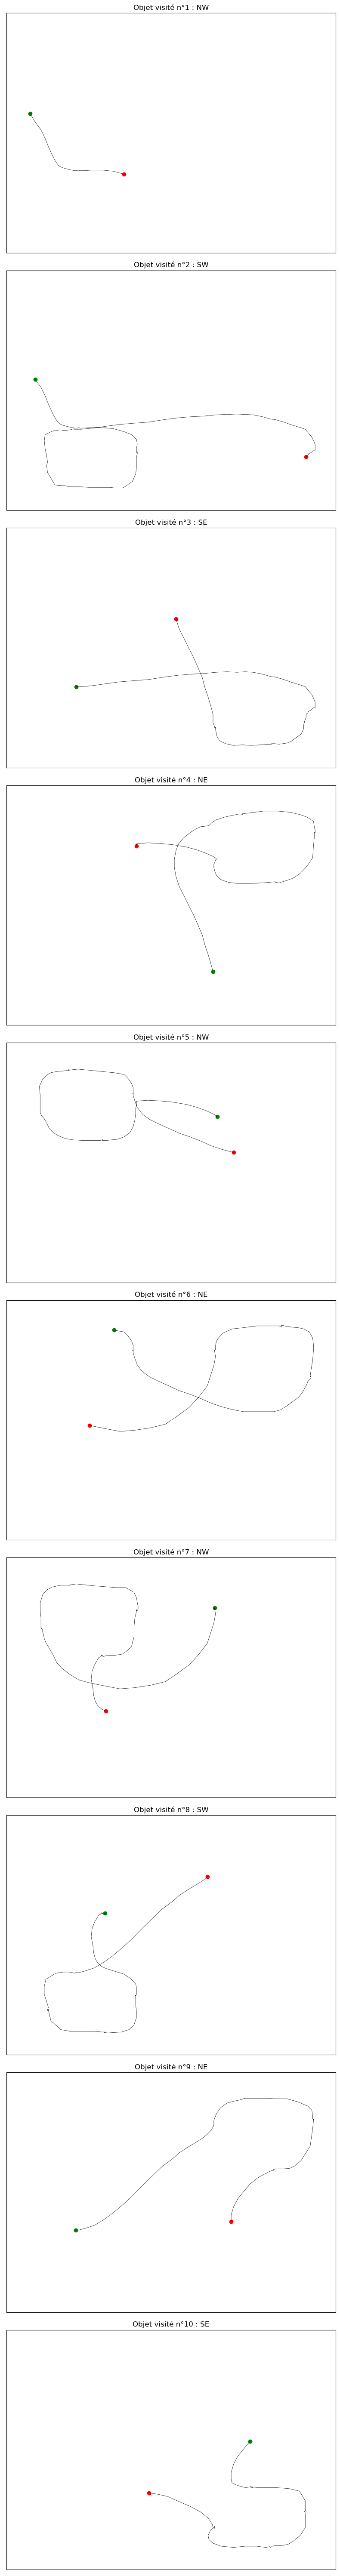

In [76]:
# Limite de la taille du cadre
frame_size = 270
n=min(len(objets_visites), 10)

# Création de sous-graphiques pour chaque objet visité
fig, axs = plt.subplots(n, figsize=(8, 6 * n))

# Itération sur les objets visités
for i, objet_visite in enumerate(objets_visites[:n]):
    # Filtrage des données de trajectoire pour l'objet visité actuel
    #traj_df_objet = traj_df[(traj_df['time'] >= df.iloc[i]["temps d'entrée"]) & (traj_df['time'] <= df.iloc[i]["temps de sortie"])]
    traj_df_objet = filter_trajectory_around_time(traj_df, df.iloc[i]["temps d'entrée"], df.iloc[i]["temps de sortie"])

    # Calcul des coordonnées de début et de fin de la trajectoire
    x_debut = traj_df_objet['xposition'].iloc[0]
    y_debut = traj_df_objet['yposition'].iloc[0]
    x_fin = traj_df_objet['xposition'].iloc[-1]
    y_fin = traj_df_objet['yposition'].iloc[-1]

    # Calcul de la plage d'affichage des axes pour centrer le début de la trajectoire
    #x_lim_min = max(0, x_debut - frame_size/2)
    #x_lim_max = min(500, x_debut + frame_size/2)
    #y_lim_min = max(0, y_debut - frame_size/2)
    #y_lim_max = min(500, y_debut + frame_size/2)

    # Création du graphique de trajectoire
    axs[i].plot(traj_df_objet['xposition'], traj_df_objet['yposition'], linewidth=0.5, c='k')
    axs[i].scatter(x_debut, y_debut, color='green', label='Début')  # Point vert au début
    axs[i].scatter(x_fin, y_fin, color='red', label='Fin')          # Point rouge à la fin
    #axs[i].set_xlim(x_lim_min, x_lim_max) # Etait utilisé pour centrer la trajectoire
    #axs[i].set_ylim(y_lim_min, y_lim_max) # Etait utilisé pour centrer la trajectoire
    axs[i].set_xlim(50, 450)
    axs[i].set_ylim(50, 450)
    axs[i].set_title(f"Objet visité n°{i+1} : {objet_visite}")

    # Supprimer les graduations sur les axes X et Y
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Affichage des graphiques
plt.tight_layout()
plt.show()

In [77]:
# Test print traj_df_objet
print(traj_df_objet)

       time  xposition  yposition
706  44.169      346.0      264.0
707  44.208      338.0      251.0
708  44.251      331.0      239.0
709  44.289      326.0      226.0
710  44.330      323.0      212.0
..      ...        ...        ...
790  47.531      274.0      155.0
791  47.571      259.0      164.0
792  47.610      246.0      172.0
793  47.652      233.0      176.0
794  47.689      223.0      178.0

[89 rows x 3 columns]


In [78]:
# Test print traj_df
print(traj_df)

          time  xposition  yposition
0       15.915       79.0      282.0
1       15.956       85.0      268.0
2       15.994       92.0      255.0
3       16.033       97.0      241.0
4       16.075      101.0      227.0
...        ...        ...        ...
17589  719.847      462.0      245.0
17590  719.890      462.0      245.0
17591  719.930      462.0      245.0
17592  719.970      462.0      245.0
17593  720.009      462.0      245.0

[17594 rows x 3 columns]


#### Second : plot the trajectory of every QT individually around the visited objects
##### Every trajectory must start in the middle of a graph, the graph is centered around each object
##### Also done for the 10 first visited objects

In [79]:
# Fonction pour définir les patchs
# Sera surement à rajouter dans le fichier own_Functions in fine

def trapezes_from_patch(patch, width):
    """
    generate the trapezes coordinates surrounding a patch
    inputs:
    patch - coordinates of a patch [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]]
    width - width of the trapeze in pixels
    outputs:
    coordinates [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]] for the 4 trapezes.
    """

    N = [patch[0], patch[1], [patch[1][0]+width, patch[1][1]+width], [patch[0][0]-width, patch[0][1]+width]]
    E = [patch[1], patch[2], [patch[2][0]+width, patch[2][1]-width], [patch[1][0]+width, patch[1][1]+width]]
    S = [patch[2], patch[3], [patch[3][0]-width, patch[3][1]-width], [patch[2][0]+width, patch[2][1]-width]]
    W = [patch[3], patch[0], [patch[0][0]-width, patch[0][1]+width], [patch[3][0]-width, patch[3][1]-width]]
    return N, E, S, W

In [80]:
# Calcul des coordonnées des patchs et assimile chaque patch à un nom cardinal (NE, SE etc...)
# Peut-on en faire une fonction ? ou en tout cas le simplifier (dictionnaire ou autre) ?

NWpatch_coords = [[104, Resolution[1] -  125], [173, Resolution[1] -  125], [173, Resolution[1] -  201], [104, Resolution[1] -  201]]
NEpatch_coords = [[330, Resolution[1] -  120], [400, Resolution[1] -  120], [400, Resolution[1] -  200], [330, Resolution[1] -  200]]
SWpatch_coords = [[109, Resolution[1] -  351], [181, Resolution[1] -  351], [181, Resolution[1] -  410], [109, Resolution[1] -  410]]
SEpatch_coords = [[330, Resolution[1] -  350], [400, Resolution[1] -  350], [400, Resolution[1] -  410], [330, Resolution[1] -  410]]

collection_trapeze = {"NW" : dict(), "NE" : dict(), "SW" : dict(), "SE" : dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)

In [81]:
# Analyse de la trajectoire à partir de la fonction trouvée dans AnalyzesGeneration_06 (définie dans own_Functions)
# Analyse faite à partir de la fonction d'Alice, si des choses ne sont pas bien définies dans la fonction, il faudra les changer plus tard directement dans own_Functions
# + définition de variables pour la fonction 

time = traj_df['time'].to_numpy()
xposition = traj_df['xposition'].to_numpy()
yposition = traj_df['yposition'].to_numpy()
yposition = Resolution[1] - yposition #yposition is inverted, puts it back in the right way
xgauss = smooth(xposition, true_sigma) ; ygauss = smooth(yposition, true_sigma) #Smoothes the positions with true sigma

distance, speed, time_average, acceleration, angles, angular_speed, list_epochs = analysis_trajectory(
        time, xgauss, ygauss, collection_trapeze, turns_df, true_cut_speed, true_ecart_angle, Resolution,
        MIN_DURATION_EPOCH= MINIMAL_DURATION_EPOCH, MIN_DURATION_STOP= MINIMAL_DURATION_STOP)

In [82]:
# Cellule avec la partie de l'ancien code d'Alice qui m'intéresse (faire la liste des QT selon ses critères)

list_quarter_turn = [epoch for epoch in list_epochs if epoch[2][0] == "Q"] #Gets the list of all quarter turns

#Creates a list for each type of quarter turn
rewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'G']
unrewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] != 'G']
extra = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'E']
badDirection = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'B']
wrongObject = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'O']
doubleWrong = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'H']

anti_clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]
clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]
exploring = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'X']

when_reward = [[turns_df.loc[a, "time"], turns_df.loc[a, "currentPatch"]] for a in turns_df.index if turns_df.loc[a, "Rewarded"]]
when_no_reward = [[turns_df.loc[a, "time"], turns_df.loc[a, "currentPatch"]] for a in turns_df.index if not turns_df.loc[a, "Rewarded"]]

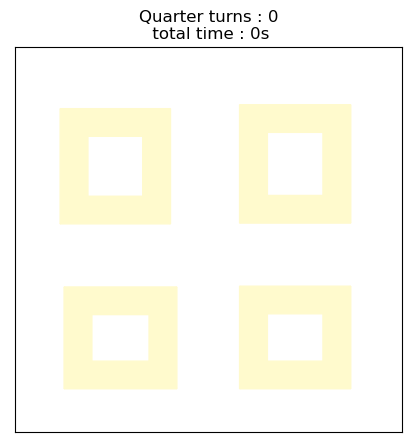

In [90]:
# Cellule avec la partie de l'ancien code d'Alice qui m'intéresse (plot des trajectoires des QT spécifiquement)

nb_column = 1 #one for each type of trajectory 
nb_line = 1 #one for each graph to be plotted

max_height_speed = []
max_height_angular = []
max_height_accel = []

fig = plt.figure(figsize = (5 * nb_column, 5 * nb_line))
for a in range(nb_column):
    current_movements = [list_quarter_turn][a] # Only QT for this plot

#Plots the trajectory of the current mod
    ax  = fig.add_subplot(nb_line, nb_column, 1 + a)
    for patch in collection_trapeze :#plot the trapeze around the object
        for trapeze in collection_trapeze[patch] :
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color = "lemonchiffon")
            ax.add_patch(shape)

        for u in current_movements :#plot each individual trajectory of the current category
            colors = plt.cm.rainbow(np.random.random())
            if len(u) != 0 :
                ax.plot( xgauss[u[0] : u[1]], ygauss[u[0] : u[1]], linewidth = 0.5, c = colors )
            else : pass
        
    
#Plots a colored dot at the begining and end of each epoch
    indices_start = [u[0] for u in current_movements]
    indices_end = [u[1] for u in current_movements]
    if len(indices_start) != 0 or len(indices_end)!= 0 :
        ax.scatter(xgauss[indices_start], ygauss[indices_start], linewidths= 0.1, color = "green")
        ax.scatter(xgauss[indices_end], ygauss[indices_end], linewidths= 0.1, color = "red")
    else : pass
        
    timeSpentIn = round(sum([turns_df.loc[df.index[epoch[1]], 'time'] - turns_df.loc[df.index[epoch[0]], 'time'] for epoch in current_movements]), 2)

#Sets the parameters of the graph
    ax.set_ylim(0, 500); ax.set_xlim(0, 500)
    ax.set_title(["Quarter turns : "][a] + str(len(current_movements)) + f"\n total time : {timeSpentIn}s")
    plt.xlim(12, 500); plt.ylim(12, 500)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()